## Проект e-commerce


#### Цель проекта: 
Проанализировать покупки в интернет-магазине и в ходе исследования ответить на следующие вопросы:

- Сколько пользователей, совершивших покупку только один раз?
- Сколько заказов в месяц в среднем не доставляется по разным причинам (детализация по причинам)? 
- По каждому товару определить, в какой день недели товар чаще всего покупается?
- Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
- Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.
- Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. Для каждого RFM-сегмента построить границы метрик recency, freqency и monetary для интерпретации этих кластеров. 
- Предварительно необходимо провести исследование данных и сформулировать, что должно считаться покупкой.

#### Входные данные:

- olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей 

customer_id — позаказный идентификатор пользователя\
customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)\
customer_zip_code_prefix — почтовый индекс пользователя\
customer_city — город доставки пользователя\
customer_state — штат доставки пользователя

- olist_orders_dataset.csv —  таблица заказов

order_id — уникальный идентификатор заказа (номер чека)\
customer_id — позаказный идентификатор пользователя\
order_status — статус заказа\
order_purchase_timestamp — время создания заказа\
order_approved_at — время подтверждения оплаты заказа\
order_delivered_carrier_date — время передачи заказа в логистическую службу\
order_delivered_customer_date — время доставки заказа\
order_estimated_delivery_date — обещанная дата доставки

- olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id — уникальный идентификатор заказа (номер чека)\
order_item_id — идентификатор товара внутри одного заказа\
product_id — ид товара (аналог штрихкода)\
seller_id — ид производителя товара\
shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике\
price — цена за единицу товара\
freight_value — вес товара

— Пример структуры данных для визуализизации по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:
created — создан, approved — подтверждён, invoiced — выставлен счёт, processing — в процессе сборки заказа, shipped — отгружен со склада, delivered — доставлен пользователю, unavailable — недоступен, canceled — отменён

In [4]:
/opt/tljh/user/bin/python -m pip install --upgrade pip

NameError: name 'opt' is not defined

In [5]:
pip install squarify

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas            as pd
import numpy             as np 
import matplotlib.pyplot as plt
import seaborn           as sns
import sys
import requests
import warnings
import squarify
from datetime import timedelta
from urllib.parse import urlencode
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [7]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize': (16, 8)},
        )

In [31]:
# Определение функции получения датафрейма (далее - df) через передачу на вход ссылки на файл на Яндекс Диске

def yd_to_df (ptf: str) -> pd.DataFrame:
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=ptf))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return pd.read_csv(download_url)

In [32]:
customers = yd_to_df ('https://disk.yandex.ru/d/QXrVDUoQvFhIcg') # таблица с уникальными идентификаторами пользователей

In [33]:
orders = yd_to_df ('https://disk.yandex.ru/d/0zWmh1bYP6REbw') # таблица заказов

In [34]:
items = yd_to_df ('https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg') # таблица товарных позиций, входящих в заказы

In [35]:
# отключим предупреждения об использовании устаревших функциий
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Начнем анализ трех таблиц
#### Посмотрим на первые строки, чтобы понять структуру таблиц

In [36]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [37]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [38]:
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


 #### Проверим тип данных и пропущенные значения

In [39]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [40]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [41]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


#### Проверим число дублирующихся строк

In [42]:
customers.duplicated().sum()

0

In [43]:
orders.duplicated().sum()

0

In [44]:
items.duplicated().sum()

0

#### Проверим статистическую информацию о числовых признаках таблицы

In [45]:
customers.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


In [46]:
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


### Опишем некоторые наблюдения, исходя из предварительного анализа трех таблиц:
- таблица costumers и таблица orders имеют общую колонку costumer_id
- таблица orders и таблица items имеют общую колонку order_id
- в таблицах orders и items колонки с датами имеют тип данных object
- в таблице orders в трех колонках имеются пропущенные значения-возможно, не в связи с ошибкой данных, а в связи с некоторыми процессами заказов

#### Переведем в таблицах orders и items колонки с датами с object на datetime

In [47]:
orders.order_purchase_timestamp      = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_approved_at             = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date  = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)
items.shipping_limit_date            = pd.to_datetime(items.shipping_limit_date)

### Понятие 'покупка'

Прежде чем приступим к решению задач, необходимо сформулировать, что должно считаться покупкой:

для решения задачи покупкой должен считаться заказ, у которого статусы и значения доставки имеют следующие обозначения:

- delivered
- order_approved_at.notna() \
Это связано с тем, что при покупке через Интернет-магазин переход права собственности на товар от продавца к покупателю происходит именно в момент вручения товара последнему. Это предусмотрено с п. 2 ст. 499 ГК РФ. Поэтому для нас будет логично отталкиваться от уже доставленного и уже оплаченного заказа. Понятно, что по закону покупатель в праве вернуть товар в течение двух лет при обнаружении брака (если будет доказано, что брак производственный), но мы пока не будем рассматривать потенциальные возвраты. \
Одного статуса delivered будет мало, так как у нас есть оплаченные заказы, но еще не доставлены, соответственно, эти заказы могут быть отменены покупателем или продавцом на этапах транспортировки (например, товар утерян, поврежден) и сборки (например, выявленный брак). А так же, есть доставленные заказы, но не оплаченные, такие результаты нас пока тоже не будут интересовать, так как не произошел весь процесс покупки, для того, чтоб считать ее успешной.
Для наглядности смотреть таблицы ниже.


- != canceled 
- != unavailable \
 В п. 4 ст. 23.1 Закона о защите прав потребителей отражено положение о возврате уплаченной за товар суммы и о полном возмещении убытков подлежат удовлетворению продавцом в течение десяти дней со дня предъявления соответствующего требования. То есть, если товар был недоступен или отменен покупателем, денежные средства на счет покупателя вернутся либо день в день (как отмена транзакции), либо путем возврата в течение десяти дней. \
Для нашего анализа эти статусы будут нерелевантны, так как фактически не произошло прибыли для компании за реализацию товара.

P.S. Не смотря на то, что заказы из анализируемых таблиц, как я понимаю, созданы явно не на российских сайтах, хотя я ссылаюсь на законы РФ, не будем считать это ошибкой. Так как мне просто важно показать ход своих мыслей :)


In [48]:
# оплаченные заказы, но не доставлены
orders_not_delivered = orders.query("order_status != 'delivered' & order_approved_at.notna()")
orders_not_delivered.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


In [49]:
# доставленные заказы, но не оплаченные
orders_not_approved = orders.query("order_status == 'delivered' & order_approved_at.isnull()")
orders_not_approved.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20


### Задание # 1
    Сколько у нас пользователей, которые совершили покупку только один раз?

#### Для начала отберем данные по покупкам по нашим четырем условиям

In [50]:
purchases = orders[(orders.order_status == 'delivered')  &
                   (orders.order_approved_at.notna())    & 
                   (orders.order_status != 'canceled')   & 
                   (orders.order_status != 'unavailable')]
purchases.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


#### Соединим таблицы 

In [51]:
purchases_customers = pd.merge(purchases, customers, on='customer_id')
purchases_customers.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


#### Найдем количество покупателей, которые совершили покупку только 1 раз

In [52]:
purchases_customers \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .query('order_id == 1') \
    .order_id.value_counts()

1    90545
Name: order_id, dtype: int64

#### Ответ: 
90545 человек совершили покупку только 1 раз.

### Задание # 2
    Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Возьмем в расчет, что 'не доставляются'- это два статуса: canceled и unavailable. 
Но для общей информации и наглядности посмотрим все статусы заказов, кроме delivered.

#### Добавим колонку со значением год-месяц

In [53]:
orders['year_month'] = orders.order_approved_at.dt.to_period('M')

#### Посчитаем количество заказов в разбивке по статусу заказа и месяцам

In [54]:
monthly_status_orders = orders \
    .query("order_status != 'delivered'") \
    .groupby(['year_month', 'order_status'],as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'orders_count'})

#### Посчитаем среднемесячное число заказов с разбивкой по их статусам 

In [55]:
monthly_status_orders_mean = monthly_status_orders \
    .groupby('order_status', as_index=False) \
    .agg({'orders_count':'mean'}) \
    .rename(columns={'orders_count' : 'orders_mean'}) \
    .sort_values(by='orders_mean', ascending=False) \
    .round(2)
monthly_status_orders_mean

,order_status,orders_mean
4,shipped,50.32
5,unavailable,29.00
1,canceled,23.05
3,processing,15.84
2,invoiced,14.95
0,approved,1.00


#### Построим график со среднемесячным числом заказов с разбивкой по их статусам 

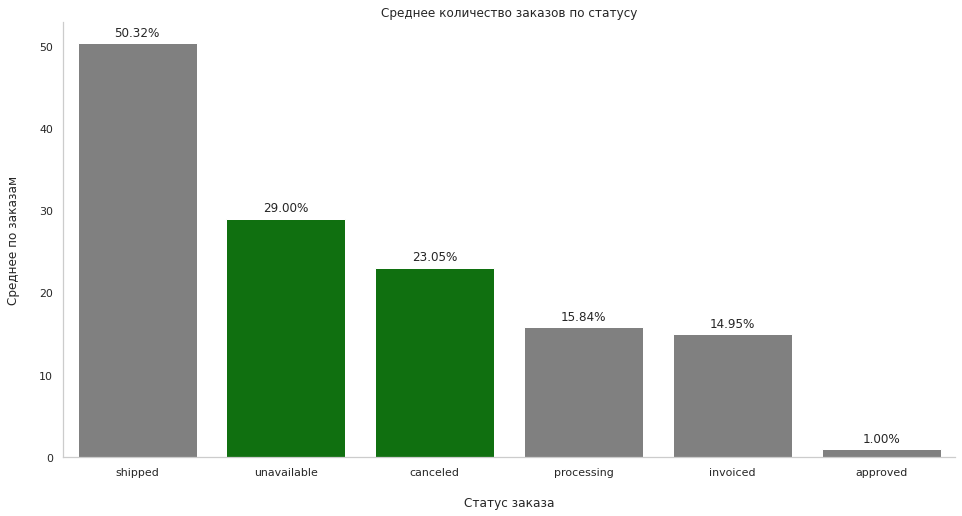

In [56]:
custom_colors = ['gray', 'green', 'green', 'gray', 'gray', 'gray']
ax = sns.barplot(x='order_status', y='orders_mean', data=monthly_status_orders_mean, palette=custom_colors)
ax.set(title='Среднее количество заказов по статусу', xlabel='\nСтатус заказа', ylabel='Среднее по заказам\n')
for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 0.5), ha='center', va='bottom')
sns.despine()
plt.grid(False)
plt.show()

#### Ответ: 
Итак, мы увидели на графике и в таблице, что есть разные причины, которые влияют на недоставку заказов покупателям. Все статусы кроме unavailable и canceled нам говорят о том, что идет процесс приобретения заказа и в скором времени заказы либо доставятся, либо отменятся. Поэтому нас интресуют два статуса unavailable и canceled, которые указывают на то, что заказ невозможно доставить покупателю:
23.05 заказов в месяц в среднем не доставляются по причине отмены заказа, а 29.00 заказов в месяц в среднем недоступны для заказа (для наглядности выделены зеленым на графике).

### Задание # 3
    По каждому товару определить, в какой день недели товар чаще всего покупается.

Будем считать, что покупка в данном задании- это как раз, день и время оплаты своего заказа, то есть, order_purchase_timestamp.

#### Здесь нам нужны два датафрейма: orders и items. Соединим их по колонке order_id

In [57]:
orders_items = pd.merge(orders, items, on='order_id')
orders_items.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


#### Добавим колонку day_of_the_week для анализа информации о дате и времени совершения заказа

In [58]:
orders_items['day_of_the_week'] = orders_items['order_purchase_timestamp'].dt.day_name()

#### Добавим колонку с днями недели и агрегируем данные по id продукта, используя моду

In [59]:
days_purchase = orders_items \
    .groupby('product_id') \
    .agg({'day_of_the_week': pd.Series.mode}) \
    .reset_index()
days_purchase.head()

,product_id,day_of_the_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


#### Ответ отображен в таблице выше в колонке day_of_the_week.

### Задание # 4
    Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

#### Выведем необходимые нам столбцы из таблицы с покупателями и покупками для дальнейшей работы 

In [60]:
purchases_week_month = purchases_customers[['customer_id', 'customer_unique_id', 'order_id', 'order_purchase_timestamp']]
purchases_week_month.head(3)

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49


#### Создадим колонки с месяцами и неделями по дате оплаты, то есть "покупки"

In [61]:
# копируем исходный df, чтобы не выпадало предупреждение
purchases_week_month_copy = purchases_week_month.copy()

purchases_week_month_copy['week']         = pd.to_datetime(purchases_week_month_copy['order_purchase_timestamp']).dt.to_period('W')
purchases_week_month_copy['week_of_year'] = purchases_week_month_copy['order_purchase_timestamp'].dt.isocalendar().week
purchases_week_month_copy['month']        = pd.to_datetime(purchases_week_month_copy['order_purchase_timestamp']).dt.to_period('M')
purchases_week_month_copy.head(3)

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,week,week_of_year,month
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02/2017-10-08,40,2017-10
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-23/2018-07-29,30,2018-07
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-06/2018-08-12,32,2018-08


#### Вычислим минимальное и максимальное значение в датах для более точного анализа

In [62]:
print(purchases_week_month_copy['order_purchase_timestamp'].min(),
      purchases_week_month_copy['order_purchase_timestamp'].max(), sep='\n\n')

2016-09-15 12:16:38

2018-08-29 15:00:37


#### Посчитаем количество дней и недель в месяцах 

In [63]:
purchases_week_month_copy['days_in_month'] = purchases_week_month_copy.order_purchase_timestamp.dt.daysinmonth

In [64]:
purchases_week_month_copy['weeks_in_month'] = round(purchases_week_month_copy.days_in_month / 7,3)

#### Посчитаем количество недель отдельно  в неполных месяцах в сентябре 2016 и в августе 2018

In [65]:
# в сентябре 2016 отсчет с 15 числа, учитывая это, рассчитаем количество недель в месяце 
round(15 / 7,3)

2.143

In [66]:
# в августе 2018 всего был 31 день, но у нас в таблице "продающих" дней всего 29, учтем это
round(29 / 7,3)

4.143

####  Перезапишем значения среднего количества недель в сентябре 2016 и в августе 2018- минимальное и максимальное значение

In [67]:
purchases_week_month_copy['weeks_in_month'].where(~(purchases_week_month_copy.month == '2016-09'), other=2.143, inplace=True) 
purchases_week_month_copy[purchases_week_month_copy.month == '2016-09']

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,week,week_of_year,month,days_in_month,weeks_in_month
29805,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,2016-09-12/2016-09-18,37,2016-09,30,2.143


In [68]:
purchases_week_month_copy['weeks_in_month'].where(~(purchases_week_month_copy.month == '2018-08'), other=4.143, inplace=True)
purchases_week_month_copy[purchases_week_month_copy.month == '2018-08'].head(1)

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,week,week_of_year,month,days_in_month,weeks_in_month
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-06/2018-08-12,32,2018-08,31,4.143


#### Создадим df с группировкой по уникальным покупателям, месяцу и неделе

In [69]:
count_of_orders = purchases_week_month_copy \
    .groupby(['customer_unique_id','month','weeks_in_month'],as_index=False) \
    .agg({'order_id':'nunique'}) \
    .rename(columns={'order_id':'total_purchases'})

#### Посчитаем среднее количество покупок в неделю для каждого пользователя

In [70]:
count_of_orders['avg_purchases_per_week'] = round(count_of_orders.total_purchases / count_of_orders.weeks_in_month,2)

In [71]:
count_of_orders = count_of_orders \
    .sort_values('avg_purchases_per_week',ascending=False) \
    .sort_values('month').sort_values('avg_purchases_per_week',ascending=False)
count_of_orders

,customer_unique_id,month,weeks_in_month,total_purchases,avg_purchases_per_week
7099,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.429,6,1.35
67352,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.000,4,1.00
60363,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4.000,4,1.00
23221,3e43e6105506432c953e165fb2acf44c,2018-02,4.000,4,1.00
74549,c8460e4251689ba205045f3ea17884a1,2018-08,4.143,4,0.97
...,...,...,...,...,...
93982,fcc0eabefd543a3882697a2b525866ba,2017-12,4.429,1,0.23
66952,b3d058d052b1ca40cd60c15f71a29a63,2017-12,4.429,1,0.23
66328,b209eaffa2dafc66ec578e3b7c1ee790,2017-12,4.429,1,0.23
42398,71d23916b85c754df18166d08fbdeb06,2017-12,4.429,1,0.23


#### Ответ отображен в таблице выше в колонке avg_purchases_per_week.

### Задание # 5
    Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с 
    самым высоким retention на 3й месяц.

Перед приведением когортного анализа необходимо определить четыре параметра:
   - Признак формирования когорты - признак для разделения по группам, в нашем случае- это месяц покупки покупателя,
   - Размер когорты - это месяц,
   - Отчетный период - это период с января по декабрь 2017 года,
   - Анализируемый показатель - это Retention Rate.

#### Создадим df, который будет содержать только уникальных пользователей c датами покупок и номерами заказов

In [72]:
cohort_purchases = purchases_customers[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]
cohort_purchases.head(3)

,customer_unique_id,order_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49


#### Добавим колонку по месяцам

In [73]:
# копируем исходный df, чтобы не выпадало предупреждение
cohort_purchases_copy = cohort_purchases.copy()

cohort_purchases_copy['month'] = pd.to_datetime(cohort_purchases_copy['order_purchase_timestamp']).dt.to_period('M')

#### Создадим колонку first_order_month, которая будет нам показывать первый заказ покупателя

In [74]:
cohort_first_purchases = cohort_purchases_copy \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'month': 'min'}) \
    .rename(columns={'month': 'first_order_month'})
cohort_first_purchases.head(3) 

,customer_unique_id,first_order_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03


#### Объединим таблицу cohort_purchases_copy и cohort_first_purchases по ключу customer_unique_id

In [75]:
cohort_merged_df = pd.merge(cohort_purchases_copy, cohort_first_purchases, on='customer_unique_id')

#### Вычислим разницу по месяцам между датой повторного заказа пользователя и первым его заказом- колонка month_lifetime

In [76]:
cohort_merged_df['month_lifetime'] = (cohort_merged_df['month'] - cohort_merged_df['first_order_month']).apply(lambda x: x.n)
cohort_merged_df.head(3)

,customer_unique_id,order_id,order_purchase_timestamp,month,first_order_month,month_lifetime
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,2017-09,1
1,7c396fd4830fd04220f754e42b4e5bff,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,2017-09,2017-09,0
2,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07,2018-07,0


#### Отберем значения даты заказов, которые приходятся на период с января 2017 г. по декабрь 2017 г.

In [77]:
cohort_2017 = cohort_merged_df[
(cohort_merged_df['first_order_month'].between("2017-01", "2017-12")) & (cohort_merged_df['month_lifetime'] < 12)]
                
cohort_2017.head(3)

,customer_unique_id,order_id,order_purchase_timestamp,month,first_order_month,month_lifetime
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,2017-09,1
1,7c396fd4830fd04220f754e42b4e5bff,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,2017-09,2017-09,0
4,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11,2017-11,0


 #### Произведем аггрегацию по покупателям по когортам

In [78]:
cohort_unique_id = cohort_2017 \
    .groupby(['first_order_month', 'month', 'month_lifetime'], as_index=False) \
    .agg(user_count=('customer_unique_id', 'nunique'))

cohort_unique_id.head(3)

,first_order_month,month,month_lifetime,user_count
0,2017-01,2017-01,0,715
1,2017-01,2017-02,1,2
2,2017-01,2017-03,2,2


#### Создадим сводную таблицу, которая будет содержать информацию о количестве уникальных пользователей в зависимости от месяца первого заказа  и времени прошедшего с месяца первого заказа

In [79]:
cohort_pivot = cohort_unique_id.pivot_table(index='first_order_month',
                                          columns='month_lifetime',
                                           values='user_count')
                                     
cohort_pivot

month_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-01,715.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02,1616.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0
2017-04,2256.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0
2017-05,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0,12.0
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0,9.0,11.0
2017-07,3752.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0
2017-08,4057.0,28.0,14.0,11.0,14.0,21.0,12.0,11.0,6.0,6.0,10.0,8.0
2017-09,4004.0,28.0,22.0,11.0,18.0,9.0,9.0,10.0,11.0,7.0,10.0,3.0


 #### Построим пивот с retention на основе предыдущей таблицы

In [80]:
# получим значения первого месяца для каждой когорты
first_month_values = cohort_pivot.iloc[:, 0]

In [81]:
# поделим значения cohort_pivot на значения первого месяца и умножение на 100 для получения retention в процентах
retention_pivot = cohort_pivot.divide(first_month_values, axis=0)* 100
retention_pivot

month_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-01,100.0,0.279720,0.279720,0.139860,0.419580,0.139860,0.419580,0.139860,0.139860,NaN,0.419580,0.139860
2017-02,100.0,0.185644,0.309406,0.123762,0.433168,0.123762,0.247525,0.185644,0.061881,0.185644,0.123762,0.309406
2017-03,100.0,0.439473,0.359569,0.399521,0.359569,0.159808,0.159808,0.319616,0.319616,0.079904,0.359569,0.119856
2017-04,100.0,0.620567,0.221631,0.177305,0.265957,0.265957,0.354610,0.310284,0.310284,0.177305,0.265957,0.088652
2017-05,100.0,0.463634,0.463634,0.289771,0.289771,0.318748,0.405680,0.144886,0.260794,0.260794,0.260794,0.347725
2017-06,100.0,0.493908,0.395127,0.428054,0.296345,0.395127,0.362200,0.230491,0.131709,0.197563,0.296345,0.362200
2017-07,100.0,0.533049,0.346482,0.239872,0.293177,0.213220,0.319829,0.106610,0.186567,0.266525,0.213220,0.293177
2017-08,100.0,0.690165,0.345083,0.271136,0.345083,0.517624,0.295785,0.271136,0.147893,0.147893,0.246488,0.197190
2017-09,100.0,0.699301,0.549451,0.274725,0.449550,0.224775,0.224775,0.249750,0.274725,0.174825,0.249750,0.074925


#### Ответ:
самый высокий retention - это когорта людей, которые вернулись и совершили покупку в июне - 0.428054.

### Задание #6
Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. Для каждого RFM-сегмента построить границы метрик recency, freqency и monetary для интерпретации этих кластеров.

 В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

RFM — это метод, используемый для анализа потребительской ценности.
Он группирует клиентов на основе истории их транзакций:
- Recency (Давность) — Как давно клиент совершил покупку?
- Frequency (Частота) — Как часто они совершают покупки?
- Monetary Value (Денежная ценность) — Сколько они тратят?

RFM-анализ позволяет ответить на вопросы:
- Кто наши лучшие клиенты?
- Кого из клиентов необходимо удерживать всеми силами?
- Кто из клиентов наиболее лоялен к нашему бренду?
- Какой сегмент клиентов наиболее хорошо откликается на текущие рекламные кампании?
- Кто из клиентов на грани потери?
- Кого потенциально можно перевести в более платящий сегмент?
- Кто наши потерянные клиенты, на которых нужно обратить особое внимание?


#### Объединим таблицы для дальнейшего анализа


In [82]:
all_df = purchases_customers.merge(orders_items, on='order_id', how='outer')
all_df.head(3)

,order_id,customer_id_x,order_status_x,order_purchase_timestamp_x,order_approved_at_x,order_delivered_carrier_date_x,order_delivered_customer_date_x,order_estimated_delivery_date_x,customer_unique_id,customer_zip_code_prefix,...,order_delivered_customer_date_y,order_estimated_delivery_date_y,year_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_the_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149.0,...,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813.0,...,2018-08-07 15:27:45,2018-08-13,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265.0,...,2018-08-17 18:06:29,2018-09-04,2018-08,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday


 #### Создадим таблицу с необходимой аггрегацией для RFM анализа, дата покупки-  order_purchase_timestamp

In [83]:
rfm_df = all_df \
    .groupby(['order_id', 
              'order_purchase_timestamp_x', 
              'customer_unique_id'], 
               as_index=False) \
    .agg({'price': 'sum'}) \
    .rename(columns={'order_purchase_timestamp_x':'order_purchase_timestamp'})
rfm_df.head(3)

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.9
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.9
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.0


#### Создадим таблицу с +1 днем от последней покупки, чтобы не было путаницы с датой

In [84]:
NOW = rfm_df.order_purchase_timestamp.max() + timedelta(days=1)

#### Cоздадим колонку с количеством дней от  даты NOW до даты покупки

In [85]:
rfm_df['DaysSinceOrder'] = rfm_df.order_purchase_timestamp.apply(lambda x: (NOW - x).days)

 #### Создадим новый аггрегированный датафрейм со значениями RFM

In [86]:
rfm = rfm_df \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'DaysSinceOrder' : 'min',
                'order_id' : 'count',
                   'price' : 'sum'}) \
    .rename(columns={'DaysSinceOrder' : 'Recency',
                           'order_id' : 'Frequency',
                              'price' : 'Monetary'})
rfm.head(3)

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9
2,0000f46a3911fa3c0805444483337064,537,1,69.0


#### Разобьем все наши показатели по квантилям (20%-40%-60%-80%) на 5 частей:

In [87]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

- В среднем значения Recency варьируются от 92 до 382 дней. Это означает, что 20% самых "новых" клиентов совершили последнюю покупку менее 92 дней назад, в то время как 20% самых "старых" клиентов совершили последнюю покупку более 382 дней назад.

- Frequency (Частота покупок): Значения для всех квантилей равны 1.0, что означает, что все клиенты совершают покупку с одинаковой частотой. Вероятно, это означает, что у нас нет различий в частоте покупок между клиентами.

- Monetary (Денежные затраты): Значения варьируются от 39.9 до 179.9. 20% клиентов совершают меньшие денежные траты (меньше 39.9), тогда как 20% самых крупных пользователей тратят больше (больше 179.9).

Таким образом, мы можем использовать эти квантили для создания сегментов клиентов на основе их характеристик Recency, Frequency и Monetary, а точнее для определения, к какой категории клиентов относится каждый клиент:

Frequency:
- 1 - т.е. все кто хоть раз совершил у нас покупку
- 2-3 - т.е. те, кто периодически проявляет активность в нашем интернет-магазине
- т 4 до 6 вкл. - т.е. те кто достаточно активно пользуется нашим сервисом

Recency:
- 1: 0-30 дней
- 2: 31-60 дней
- 3: 61-90 дней
- 4: 91-180 дней
- 5: 181-365 дней

Оставим распределение Monetary по квантилям как есть

#### Напишем методы для присвоения рангов от 1 до 5

In [88]:
def r_score(x):
    if x   <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x   <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

#### Создадим новые колонки применяя функции по границам 

In [89]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

#### Создадим словарь  сегментов

In [90]:
segt_map = {
    r'[1-2][1-2]' : 'Спящие',
    r'[1-2][3-4]' : 'В зоне риска', 
    r'[1-2]5'     : 'Нельзя терять',
    r'3[1-2]'     : 'Малоактивные',
    r'33'         : 'Нуждающиеся во внимании',
    r'[3-4][4-5]' : 'Лояльные', 
    r'41'         : 'Перспективные',
    r'51'         : 'Новые',
    r'[4-5][2-3]' : 'Потенциальные лоялисты',
    r'5[4-5]'     : 'Чемпионы'
            }

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head() 


,customer_unique_id,Recency,Frequency,Monetary,R,F,M,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,Перспективные
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,Перспективные
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,Спящие
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,Спящие
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,Спящие



#### Описание сегментов:

- Чемпионы- покупали недавно, часто покупают и тратят больше всего.
- Лояльные- покупают на регулярной основе. Реагируют на акции.
- Потенциальные лоялисты- последние клиенты со средней частотой.
- Новые-	покупали совсем недавно, но не часто это делают.
- Перспективные-	недавние покупатели, но не тратили много.
- Нуждающиеся во внимании-	выше средней частоты покупок и стоимости покупок.
- Малоактивные-	активность ниже среднего. Потеряем их, если не будем повторно их активировать.
- В зоне риска-	покупали часто, но давно. Нужно вернуть их
- Нельзя терять-	Раньше часто покупали, но давно не возвращались.
- Спящие-	Последняя покупка была давно и было сделано мало заказов. Может быть потерян.

#### Построим график распределения клиентов по R и F и график распределения M для оценки RF

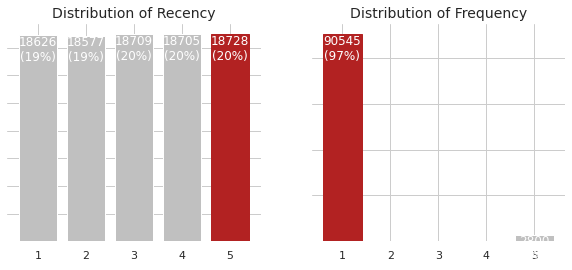

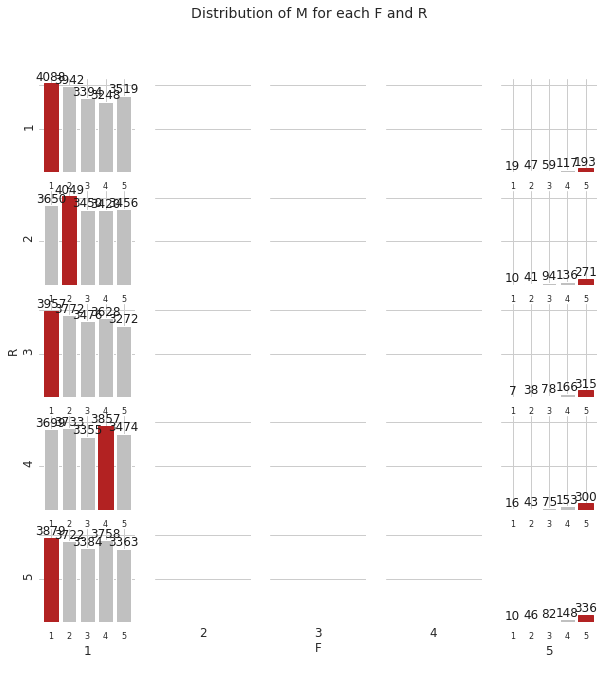

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()


fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
ax.grid(False)
plt.show()

#### Подсчитаем количество клиентов в каждом сегменте

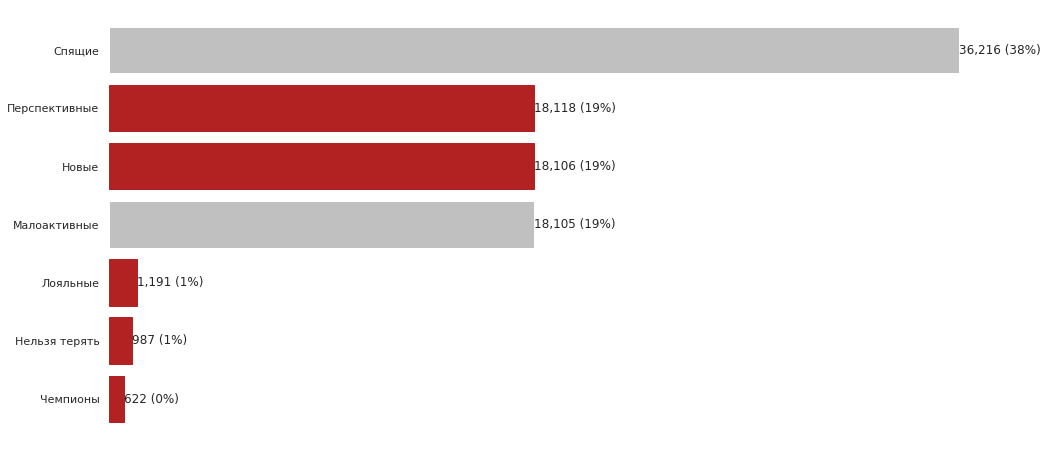

In [92]:
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Чемпионы', 'Новые', 'Перспективные', 'Лояльные', 'Нельзя терять']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
ax.grid(False)
plt.show()

#### Создадим таблицу, где будут отображены основные показатели

In [93]:
rfm_group = rfm.groupby('Segment').agg({
    'Recency' : ['mean'],
    'Frequency': ['mean'],
    'Monetary': ['mean', 'count']
}).round(1).reset_index()
rfm_group

Segment Recency Frequency Monetary       
                    mean      mean     mean  count
0       Лояльные   176.6       2.1    265.4   1191
1   Малоактивные   220.5       1.0    129.8  18105
2  Нельзя терять   382.4       2.1    246.5    987
3          Новые    45.5       1.0    138.5  18106
4  Перспективные   135.7       1.0    142.1  18118
5         Спящие   395.3       1.0    139.7  36216
6       Чемпионы    46.5       2.2    271.3    622

In [94]:
rfm_group.columns = rfm_group.columns.droplevel()
rfm_group.columns = ['Segment', 'Recency_mean', 'Frequency_mean', 'Monetary_mean', 'People_count']

rfm_group.sort_values(by='People_count', ascending=False)

,Segment,Recency_mean,Frequency_mean,Monetary_mean,People_count
5,Спящие,395.3,1.0,139.7,36216
4,Перспективные,135.7,1.0,142.1,18118
3,Новые,45.5,1.0,138.5,18106
1,Малоактивные,220.5,1.0,129.8,18105
0,Лояльные,176.6,2.1,265.4,1191
2,Нельзя терять,382.4,2.1,246.5,987
6,Чемпионы,46.5,2.2,271.3,622


#### Визуализируем получившиеся результаты сегментации для наглядности

(0.0, 100.0, 0.0, 100.0)

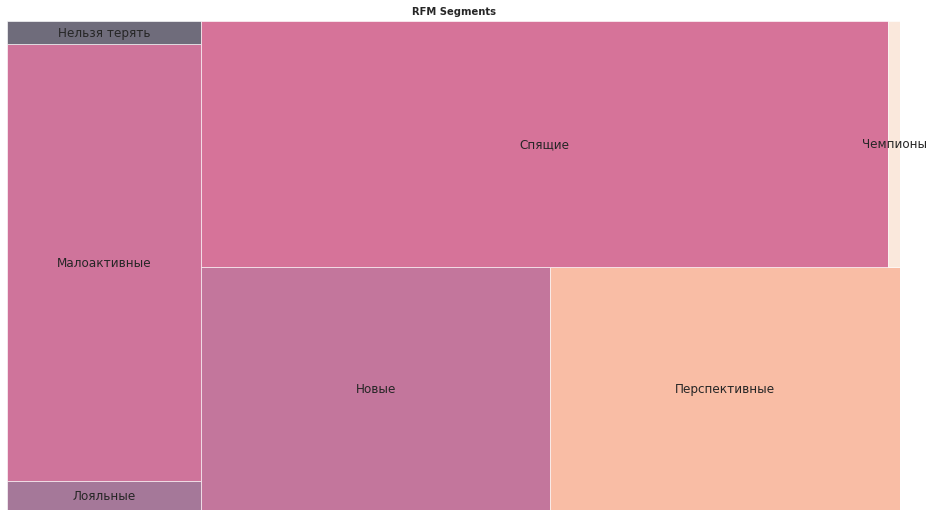

In [95]:
fig, ax = plt.subplots()
labels = rfm_group['Segment'].values
sizes = rfm_group['People_count'].values

fig.set_size_inches(16, 9)
squarify.plot(sizes=sizes, label=labels, alpha=0.6)
plt.title('RFM Segments', fontsize=10, fontweight='bold')
plt.axis('off')


Выводы:
Этот интернет-магазин, вероятно, еще только набирает обороты, он молодой, поэтому необходимо прописать план действий по увеличению показателей.

Общая тенденция: 
Из данной сегментации видно, что наиболее ценными клиентами являются лояльные и чемпионы, которые делают повторные покупки и приносят высокую денежную стоимость. Однако, существует потенциал в перспективных и новых клиентах, чтобы они стали более активными и приносили больше дохода. Тем не менее, требуется уделять внимание таким сегментам, как спящие и малоактивные клиенты, и предпринимать меры для их удержания, так как потеря таких клиентов может отрицательно сказаться на доходности бизнеса.

Спад активности у многих полльзователей можно объяснить различными факторами:
- возможно, товар, который продается в этом интернет-магазине раассчитан на долгосрочное использование и у пользователей нет необходимости обновлять этот товар часто,
- недостаток интересных и актуальных предложений или акций для пользователей, 
- недостаточная вовлеченность и коммуникация с пользователями,
- конкурентные и новые интернет-магазины, привлекающие внимание пользователей,
- проблемы с функциональностью или удобством использования интернет-магазина.

В целом, для удержания пользователей рекомендуется проводить следющие действия (ориентируясь на каждую группу людей, соответственно):

- проводить регулярный мониторинг активности пользователей и своевременно реагировать на снижение активности,
- предлагать персонализированные акции, скидки и инсентивы,
- поддерживать открытую коммуникацию с пользователями и реагировать на их запросы и обратную связь,
- постоянно внедрять новые функции и возможности, чтобы делать интернет-магазин более интересным и ценным для пользователей,
- анализировать конкурентную среду и улучшать удобство использования интернет-магазина,
- проводить ретаргетинг и коммуникацию с пользователями, которые показывали активность, но давно не взаимодействовали с интернет-магазином.